### Importação das bibliotecas necessárias

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD

### Importação dos Raw Datasets

In [28]:
df1 = pd.read_csv('../data/order_items_dataset.csv', index_col="Unnamed: 0")
df2 = pd.read_csv('../data/order_reviews_dataset.csv', index_col="Unnamed: 0")
df3 = pd.read_csv('../data/orders_dataset.csv', index_col="Unnamed: 0")
df4 = pd.read_csv('../data/products_dataset.csv', index_col="Unnamed: 0")


### Análise EDA

In [29]:
df1.head(1)

,order_id,order_item_id,product_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.9


In [30]:
df2.head(1)

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4


In [31]:
df3.head(1)

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered


In [32]:
df4.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,225.0,16.0,10.0,14.0


In [33]:
df_orders = pd.merge(df3, df2, on="order_id")
df_orders = pd.merge(df_orders, df1, on="order_id")
df_orders = pd.merge(df_orders, df4, on="product_id")

In [34]:
df_orders.head()

,order_id,customer_id,order_status,review_id,review_score,order_item_id,product_id,price,product_category_name,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,a54f0611adc9ed256b57ede6b6eb5114,4,1,87285b34884572647811a353c7ac498a,29.99,utilidades_domesticas,40.0,268.0,500.0,19.0,8.0,13.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,b46f1e34512b0f4c74a72398b03ca788,4,1,87285b34884572647811a353c7ac498a,29.99,utilidades_domesticas,40.0,268.0,500.0,19.0,8.0,13.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,dc90f19c2806f1abba9e72ad3c350073,5,1,87285b34884572647811a353c7ac498a,29.99,utilidades_domesticas,40.0,268.0,500.0,19.0,8.0,13.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,1bafb430e498b939f258b9c9dbdff9b1,3,1,87285b34884572647811a353c7ac498a,29.99,utilidades_domesticas,40.0,268.0,500.0,19.0,8.0,13.0
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,8d5266042046a06655c8db133d120ba5,4,1,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumaria,29.0,178.0,400.0,19.0,13.0,19.0


In [35]:
df_orders.describe()

,review_score,order_item_id,price,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,112372.000000,112372.000000,112372.000000,110774.000000,110774.000000,112354.000000,112354.000000,112354.000000,112354.000000
mean,4.032473,1.196010,120.378962,48.777583,786.793932,2090.610882,30.152198,16.576811,23.001210
std,1.387849,0.691243,182.152386,10.025179,651.609498,3748.608093,16.139323,13.437792,11.707552
min,1.000000,1.000000,0.850000,5.000000,4.000000,0.000000,7.000000,2.000000,6.000000
25%,4.000000,1.000000,39.900000,42.000000,348.000000,300.000000,18.000000,8.000000,15.000000
50%,5.000000,1.000000,74.900000,52.000000,601.000000,700.000000,25.000000,13.000000,20.000000
75%,5.000000,1.000000,134.900000,57.000000,985.000000,1800.000000,38.000000,20.000000,30.000000
max,5.000000,21.000000,6735.000000,76.000000,3992.000000,40425.000000,105.000000,105.000000,118.000000


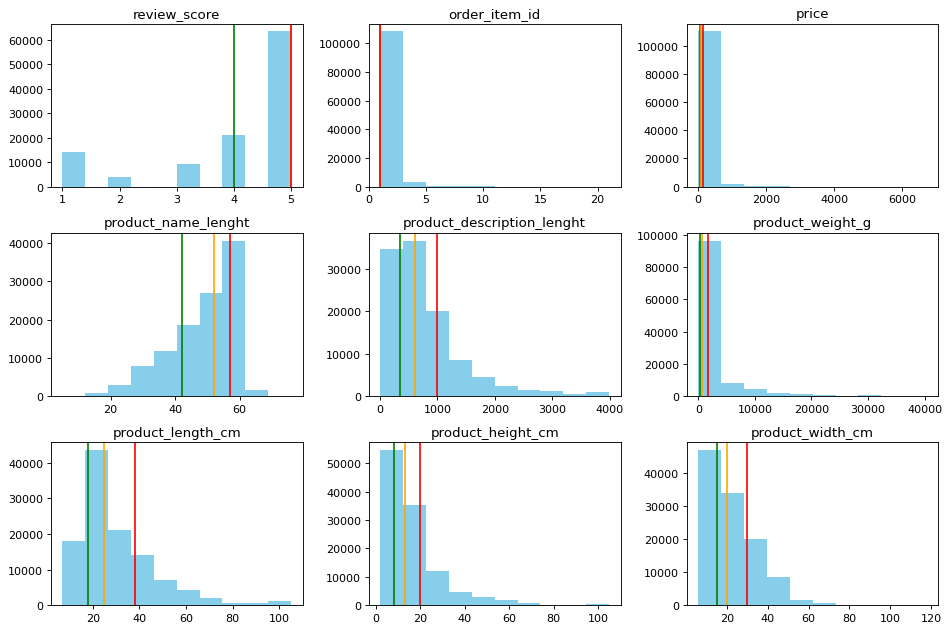

In [36]:
n_cols = 3
n_rows = 3
fig, ax = plt.subplots(n_rows, n_cols, tight_layout=True, figsize=(12, 8), dpi=80)

df_cols = df_orders.select_dtypes(include=np.number).columns

i = 0
for row in ax:
  for col in row:
    col.hist(df_orders[df_cols[i]], color = "skyblue")
    col.set_title(df_cols[i])
    col.axvline(df_orders[df_cols[i]].quantile(0.25), 0, 1, color='green')
    col.axvline(df_orders[df_cols[i]].quantile(0.5), 0, 1, color='orange')
    col.axvline(df_orders[df_cols[i]].quantile(0.75), 0, 1, color='red')
    i += 1

> 1. (review_score) A grande maioria das recomendações são de pelo menos 4 estrelas
2. (order_item_id) As compras geralmente possuem um item
1. (price) A maior parte das compras são de produtos com valor menor que 100 reais
2. (product_name_length) Os produtos mais comprados possuem entre 42 e 57 letras de nome
3. (product_description_lenght) Os produtos mais comprados possuem entre 348 e 985 letras de descrição
4. (product_weight_g) Os produtos mais comprados possuem entre 300 a 1800 g de peso
5. (product_length_cm) Os produtos mais comprados possuem entre 18 e 38 cm de comprimento
6. (product_height_cm) Os produtos mais comprados possuem entre 8 e 20 cm de altura
7. (product_width_cm) Os produtos mais comprados possuem entre 15 e 30 cm de largura

In [37]:
print(df_orders['review_score'].isna().sum())
print(df_orders['customer_id'].isna().sum())
print(df_orders['product_id'].isna().sum())

0
0
0


> As colunas mais importantes para a implementação do modelo não possuem valores nulos

### Aplicação dos algorítimos de recomendação

#### Recomendador baseado em popularidade

Criação de um subconjunto com produtos avaliados mais de 50 vezes. Este será o nosso limite

In [38]:
# Dataframe com produtos com mais de 50 avaliações
new_df = df_orders.groupby("product_id").filter(lambda x: x['review_score'].count() >= 50)

# # Criação de um novo DataFrame com classificação média e número de classificações por produto
scores_df = pd.DataFrame(new_df.groupby('product_id').review_score.mean())

# # Adicionando coluna com número de avaliações por produto
scores_df['rating_counts'] = new_df.groupby('product_id').review_score.count()

# # Visualização dos 5 produtos mais bem avaliados (número de avaliações)
scores_df.sort_values(by = 'rating_counts', ascending = False).head(5)

,review_score,rating_counts
product_id,,
aca2eb7d00ea1a7b8ebd4e68314663af,4.019084,524
422879e10f46682990de24d770e7f83d,3.946502,486
99a4788cb24856965c36a24e339b6058,3.898340,482
389d119b48cf3043d311335e499d9c6b,4.117647,391
368c6c730842d78016ad823897a372db,3.922680,388


Em seguida, definiremos uma função para calcular uma média ponderada que pega o número total de votos e o limite (50) e o multiplica pela média global e pela média do produto. A fórmula é: (v / (v + m) * R) + (m / (m + v) * C)

- (v) votos do produto;
- (m) votos mínimos GERAL;

- (R) avaliação média do produto;
- (C) avaliação GERAL de produtos

In [39]:
# Média Global das review_score
C = scores_df['review_score'].mean()

# Limite mínimo para ser elegível ao ranking
m = scores_df.rating_counts.min()

# Função que calcula a média ponderada de cada item
def weighted_rating (x, m = m, C = C):
  v = x['rating_counts']
  R = x['review_score']
  # Calcula média ponderada
  return (v/(v+m) * R) + (m/(v+m) * C)

# Adiciona a 'pontuação' calculada com weighted_rating() ao dataframe
scores_df['score'] = scores_df.apply(weighted_rating, axis=1)

# Resultado final com os 15 produtos mais populares
scores_df.sort_values(by='score', ascending=False).head(15)

,review_score,rating_counts,score
product_id,,,
73326828aa5efe1ba096223de496f596,4.833333,54,4.450744
6a8631b72a2f8729b91514db87e771c0,4.709677,62,4.409619
e0cf79767c5b016251fe139915c59a26,4.477941,136,4.359556
fbc1488c1a1e72ba175f53ab29a248e8,4.620690,58,4.350716
629e019a6f298a83aeecc7877964f935,4.561644,73,4.348596
5f504b3a1c75b73d6151be81eb05bdc9,4.555556,63,4.326348
f7a17d2c51d9df89a4f1711c4ac17f33,4.546875,64,4.323486
363218ba55c610b750224f90bdd34be1,4.465116,86,4.307922
d696750e550fd0f733979dd7e5dff921,4.526316,57,4.297919


#### Filtragem colaborativa (recomendação item-item)

In [40]:
# Lendo o dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df[['customer_id', 'product_id', 'review_score']], reader)

# Split dos dados
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

# Criação de um modelo baseado em item (user_based true / false para alternar entre filtragem colaborativa baseada em usuário ou baseada em item)
algo = KNNWithMeans(k=5, sim_options={'user_based': False})
algo.fit(trainset)

# Teste do modelo
test_pred = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [41]:
algo.get_neighbors(1, 10)

[41, 78, 82, 3, 59, 0, 2, 4, 5, 6]

In [42]:
# buscando os ID dos produtos recomendados com base no produto selecionado 
scores_df.iloc[[41, 78, 82, 3, 59, 0, 2, 4, 5, 6]].index

Index(['3fbc0ef745950c7932d5f2a446189725', '703d742887bb9267f89b675608ba7aa0',
       '777d2e438a1b645f3aec9bd57e92672c', '06edb72f1e0c64b14c5b79353f7abea3',
       '53759a2ecddad2bb87a079a1f1519f73', '0152f69b6cf919bcdaf117aa8c43e5a2',
       '06c6e01186af8b98ee1fc9e01f9471e9', '08574b074924071f4e201e151b152b4e',
       '0a57f7d2c983bcf8188589a5fea4a8da', '0aabfb375647d9738ad0f7b4ea3653b1'],
      dtype='object', name='product_id')

#### Sistema de fatoração de matriz (algoritmo SVD)

Levando em consideração customer_id e product_id (utilizando o review_score para validar correlação com base na avaliação do cliente)

In [43]:
# Cria-se uma matriz (utilizando com 50 mil linhas por motivo de uso computacional)
new_df1 = new_df.head(50000)
score_matrix = new_df1.pivot_table(values='review_score', index='customer_id', columns='product_id', fill_value=0)
score_matrix.head()

# Transposta da matriz
X = score_matrix.T
X.head()

customer_id,00066ccbe787a588c52bd5ff404590e3,000e943451fc2788ca6ac98a682f2f49,000fd45d6fedae68fc6676036610f879,001028b78fd413e19704b3867c369d3a,0015f7887e2fde13ddaa7b8e385af919,0017a0b4c1f1bdb9c395fa0ac517109c,0019c9aaad15b043c48f0a1180f22ce8,002d358e2462f87678443706cbf2eb21,003bdf7fd8312f9d14a4b979f3747334,00426311a53f3c052943c88b692a3be2,...,ffcbcec4480d074ffd50398e66bff27c,ffd940dedc35e4f459eddfa41291e824,ffdaaad4323306777060ca43b3f87e7f,ffdd80d8f3655192a9d2a38d5b18732c,ffde64401f7cb62d2e8696d9467c781d,ffe1eab23bff108bf37c973b05d4e9ba,ffeaa6d37b3691d54a01171f6562f44f,ffed5d4f6245fe13cd57054621eec36a,fff212062d600f2e1d53f3c5d4a25138,fffb97495f78be80e2759335275df2aa
product_id,,,,,,,,,,,,,,,,,,,,,
0152f69b6cf919bcdaf117aa8c43e5a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
054515fd15bc1a2029f10de97ffa9120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06c6e01186af8b98ee1fc9e01f9471e9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06edb72f1e0c64b14c5b79353f7abea3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08574b074924071f4e201e151b152b4e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Redução de dimensionalidade com Truncated SVD
SVD_model = TruncatedSVD(n_components=10)
decomposed_matrix = SVD_model.fit_transform(X)
decomposed_matrix.shape

# Matriz de Correlação
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

# Indice do produto da matriz transposta (resultante do pivot_table)
product_index = 3

# Correlação para todos os itens com o item comprado por este cliente, com base em itens avaliados por outras pessoas de clientes que compraram o mesmo produto
correlation_product_ID = correlation_matrix[product_index]
correlation_product_ID.shape

(175,)

In [45]:
# Filtro pelos registros com correlação maior que 0.7 (indicando alta correlação entre os produtos)
rocommended_products = list(X.index[correlation_product_ID > 0.7])

# Remove o item já comprado pelo cliente
rocommended_products.remove(X[product_index:product_index + 1].index[0])

# Top 3 produtos similares ao produto 06c6e01186af8b98ee1fc9e01f9471e9 recomendados para esse cliente
rocommended_products[0:3]


['165f86fe8b799a708a20ee4ba125c289',
 '24c66f106f642621e524291a895c9032',
 '25f86162fee18735fffdb762dcb10d7c']